In [1]:
class BugData:
    def __init__(
        self,
        bug_id,
        bitvector,
        bitvector_dict,
        response,
        available_bv,
        full_bv,
        full_available_bv,
        success_count,
        easy,
        facts,
    ):
        self.bug_id = bug_id
        self.bitvector = bitvector
        self.bitvector_dict = bitvector_dict
        repo = self.bug_id.split(":")[0]
        self.repo = repo
        if repo not in id_gen:
            global counter
            id_gen[repo] = counter
            counter += 1
        self.id = id_gen[repo]
        self.available_bv = available_bv
        self.easy = 1 if easy else 0
        error_dict = {
            "TypeError": 1,
            "ValueError": 2,
            "AttributeError": 3,
            "InvalidInput": 4,
        }
        self.full_bv = full_bv
        self.full_available_bv = full_available_bv
        self.error_type = 0
        self.issue_description_type = 0
        for key in error_dict:
            if key in bitvector_dict["4"]:
                self.error_type = error_dict[key]
            if key in bitvector_dict["6"]:
                self.issue_description_type = error_dict[key]
        self.response = response
        if "```text" in self.bitvector_dict["6"]:
            self.has_code = 1
        else:
            self.has_code = 0
        self.facts = facts
        self.success_count = success_count
        self.success_probability = None
        self.cyclomatic_complexity = self.compute_cyclomatic_complexity(facts["1.1.1"])
        self.prompt_length = self.compute_prompt_length()
        self.feature_vector = self.generate_feature_vector()

    def compute_cyclomatic_complexity(self, code: str):
        # Use radon to compute the cyclomatic complexity
        code = textwrap.dedent(code)
        try:
            visitor = ComplexityVisitor.from_code(code)
            # The total complexity is the sum of complexities of all blocks
            total_complexity = sum(block.complexity for block in visitor.blocks)
            return total_complexity
        except Exception as e:
            print(f"Error computing cyclomatic complexity: {e}")
            return 0

    def tokenize_and_count_nltk(self, text):
        tokens = word_tokenize(text)
        return len(tokens)

    def compute_prompt_length(self):
        su = 0
        for i, b in enumerate(self.available_bv, 1):
            if int(b) == 1:
                su += len(self.bitvector_dict[str(i)])
        return su

    def generate_feature_vector(self):
        feature = []
        #feature = [int(bit) for bit in self.bitvector]
        nv = []
        feature.append(self.cyclomatic_complexity)
        for b in self.available_bv:
            nv.append(int(b))
        feature += nv
        feature += [self.prompt_length]
        xxx[(self.cyclomatic_complexity, self.success)] = (
            xxx.get((self.cyclomatic_complexity, self.success), 0) + 1
        )
        # feature += [int(bit) for bit in self.full_bv]

        # for b1, b2 in zip(self.full_bv, self.full_available_bv):
        #    if int(b2) == 1:
        #        feature.append(1)Do you want to restart the kernel of Stats.ipynb? All variables will be lost.

        #    else:
        #        feature.append(0)

        feature.append(int(self.error_type))
        feature.append(int(self.issue_description_type))
        return feature

    @property
    def success(self):
        return self.success_count > 0


In [2]:
def top_bitvectors(bug_data_list):
    success_count = defaultdict(int)
    total = defaultdict(int)
    bug_done = set()
    for bug_data in bug_data_list:
        if bug_data.success:
            success_count[bug_data.bitvector] += 1
    for key, value in success_count.items():
        success_count[key] = success_count[key]
    # Sort by success count in descending order
    sorted_bitvectors = sorted(success_count.items(), key=lambda x: x[1], reverse=True)
    top_bitvectors_union(bug_data_list)
    # Get top 5
    return sorted_bitvectors[:30]


def top_bitvectors_union(bug_data_list):
    success_count = defaultdict(int)
    bitvector_to_bug_ids = defaultdict(set)

    for bug_data in bug_data_list:
        if bug_data.success:
            success_count[bug_data.bitvector] += 1
            bitvector_to_bug_ids[bug_data.bitvector].add(bug_data.bug_id)

    sorted_bitvectors = sorted(success_count.items(), key=lambda x: x[1], reverse=True)

    top_5_bitvectors = sorted_bitvectors[:2]

    union_of_top_bitvectors = set()
    for bitvector, _ in top_5_bitvectors:
        union_of_top_bitvectors.update(bitvector_to_bug_ids[bitvector])
    print(len(union_of_top_bitvectors))


def load_facts_in_prompt(bug_dir):
    facts_file = os.path.join(bug_dir, "facts-in-prompt.json")
    if os.path.exists(facts_file):
        with open(facts_file, "r") as file:
            return json.load(file)
    else:
        print(f"facts-in-prompt.json not found in {bug_dir}.")
        return {}


def load_data_from_excel(excel_path):
    df = pd.read_excel(excel_path)
    return df


def create_bug_data_objects(df, facts_location):
    all_data = []
    for _, row in df.iterrows():
        repo = row["Project"]
        bug_id = row["Bug_id"]
        response = row["Pass Test"]
        actual_bv = row["result_filename"].split("_")[0].strip()
        exist_bv = "".join(
            [str(row[i]) for i in range(2, 9)]
        )  # Columns 3 to 9 for bitvector        # Convert 17-bit to 7-bit bitvector
        bitvector = convert_bitvector(actual_bv)

        bug_path = os.path.join(facts_location, repo, str(bug_id))
        bitvector_dict = load_facts_in_prompt(bug_path)
        all_data.append(
            BugData(f"{repo}:{bug_id}", bitvector, bitvector_dict, response, exist_bv)
        )
    return all_data


def convert_bitvector(actual_bv):
    # Define the groupings
    groupings = [(0, 1), (2, 4), (5, 6), (7, 10), (11, 14), (15, 16), (17, 17)]
    new_bv = ""

    for start, end in groupings:
        if any(actual_bv[i] == "1" for i in range(start, end + 1)):
            new_bv += "1"
        else:
            new_bv += "0"

    return new_bv


def calculate_success_rate(bug_data_list):
    bit_sum_success = defaultdict(lambda: {"success": 0, "total": 0, "lis": set()})
    for bug_data in bug_data_list:
        bit_sum = sum(map(int, bug_data.bitvector))
        bit_sum_success[bit_sum]["total"] += 1
        if bug_data.success:
            bit_sum_success[bit_sum]["lis"].add(bug_data.bug_id)
            bit_sum_success[bit_sum]["success"] += 1
    success_rates = {}
    for bit_sum, counts in bit_sum_success.items():
        success_rates[bit_sum] = (
            counts["success"] / counts["total"] if counts["total"] > 0 else 0
        )
    top_5_bit_sums = sorted(success_rates, key=success_rates.get, reverse=True)

    return top_5_bit_sums


def plot_success_rate(success_rate):
    # Sorting the keys for a better plot
    sorted_bit_sums = sorted(success_rate.keys())
    success_rates = [success_rate[bit_sum] for bit_sum in sorted_bit_sums]

    plt.plot(sorted_bit_sums, success_rates, marker="o")
    plt.xlabel("Sum of Bits")
    plt.ylabel("Success Rate")
    plt.title("Success Rate vs Sum of Bits")
    plt.grid(True)
    plt.show()


def find_bugs_without_bitvector(all_data, target_bitvector):
    bugs_without_target = set()
    has_set = set()
    for bug_data in all_data:
        if bug_data.bitvector == target_bitvector:
            has_set.add(bug_data.bug_id)
    for bug_data in all_data:
        if bug_data.bug_id not in has_set:
            bugs_without_target.add(bug_data.bug_id)
    return bugs_without_target


def remove_duplicates(bug_data_list):
    unique = []
    for item in bug_data_list:
        if all(not item.__eq__(existing) for existing in unique):
            unique.append(item)
    return unique


def calculate_optimal_success_rate(bug_data_list):
    # Group BugData by Bug ID
    bugs = defaultdict(list)
    for data in bug_data_list:
        bugs[data.bug_id].append(data)

    # Count bugs with at least one successful bitvector
    successful_bugs = 0
    for bug_id, bug_data in bugs.items():
        if any(data.success for data in bug_data):
            successful_bugs += 1

    # Calculate success rate
    total_unique_bugs = len(bugs)
    success_rate = successful_bugs / total_unique_bugs if total_unique_bugs > 0 else 0
    return successful_bugs, total_unique_bugs


def estimate_score_normal(model, test_data):
    test_groups = {}
    for bug in test_data:
        if bug.bug_id not in test_groups:
            test_groups[bug.bug_id] = []
        test_groups[bug.bug_id].append(bug)

    successful_selections = 0
    optimal_success_count = 0

    successful_selections = 0
    optimal_success_count = 0
    best_bitvectors = {}  # To store the best bitvector for each bug_id

    threshold = 0  # Set a threshold for the highest probability score
    top_k = 5  # Consider top 5 predictions

    for bug_id, bugs in test_groups.items():
        # Get probabilities for each bug
        bug_probabilities = [
            (bug, model.predict_proba([bug.feature_vector])[0][1]) for bug in bugs
        ]

        # Sort bugs by their probability in descending order
        sorted_bugs = sorted(bug_probabilities, key=lambda x: x[1], reverse=True)
        best_bug = sorted_bugs[0][0]

        best_bitvectors[bug_id] = best_bug.bitvector  # Store the best bitvector
        if best_bug.success:
            successful_selections += 1

        # Check for optimal success in the group
        if any(bug.success for bug in bugs):
            optimal_success_count += 1
    # Calculate accuracy and optimal accuracy
    accuracy = successful_selections / len(test_groups)
    optimal_accuracy = optimal_success_count / len(test_groups)

    # Print the results
    print(
        f"Model Accuracy: {accuracy}, Optimal Accuracy: {optimal_accuracy}, Successful"
        f" Selections: {successful_selections}, Total Groups: {len(test_groups)}"
    )

    # Process each group in test_groups
    bitvector_success_rates = {}
    for bug_id, bugs in test_groups.items():
        bv_set = set()
        for bug in bugs:
            bv_set.add(bug.bitvector)
            if bug.bitvector not in bitvector_success_rates:
                bitvector_success_rates[bug.bitvector] = {"successes": 0, "total": 0}

            bitvector_success_rates[bug.bitvector]["total"] += 1
            if bug.success:
                bitvector_success_rates[bug.bitvector]["successes"] += 1

    # Calculate success rate for each bitvector
    for bitvector, stats in bitvector_success_rates.items():
        success_rate = stats["successes"] / stats["total"]
        bitvector_success_rates[bitvector]["success_rate"] = success_rate
    print(f"Best bitvector (1001011): {bitvector_success_rates['1001011']}")
    # Find the bitvectors with the highest success rates
    highest_success_rate = max(
        rate["success_rate"] for rate in bitvector_success_rates.values()
    )
    best_bitvectors = [
        (bitvector, rate)
        for bitvector, rate in bitvector_success_rates.items()
        if rate["success_rate"] == highest_success_rate
    ]

    # Print the best bitvectors
    print(f"Bitvectors with the highest success rate: {best_bitvectors}")


def estimate_score_models(models, test_data):
    # Group test_data by bug_id
    test_groups = {}
    for bug in test_data:
        if bug.bug_id not in test_groups:
            test_groups[bug.bug_id] = []
        test_groups[bug.bug_id].append(bug)

    successful_selections = 0
    optimal_success_count = 0
    best_bitvectors = {}  # To store the best bitvector for each bug_id

    threshold = 0  # Set a threshold for the highest probability score
    top_k = 5  # Consider top 5 predictions

    for bug_id, bugs in test_groups.items():
        bug_probabilities = []

        for bug in bugs:
            model_index = int(
                bug.bitvector[1:], 2
            )  # Determine which model to use based on bitvector
            selected_model = models[model_index]
            probability = selected_model.predict_proba([bug.feature_vector])[0][1]
            bug_probabilities.append((bug, probability))

        # Sort bugs by their probability in descending order
        sorted_bugs = sorted(bug_probabilities, key=lambda x: x[1], reverse=True)

        # Select best bug based on threshold and randomness
        if sorted_bugs[0][1] >= threshold:
            best_bug = sorted_bugs[0][0]
        else:
            best_bug = random.choice(sorted_bugs[:top_k])[0]

        best_bitvectors[bug_id] = best_bug.bitvector  # Store the best bitvector
        if best_bug.success:
            successful_selections += 1

        # Check for optimal success in the group
        if any(bug.success for bug in bugs):
            optimal_success_count += 1

    # Calculate accuracy and optimal accuracy
    accuracy = successful_selections / len(test_groups) if test_groups else 0
    optimal_accuracy = optimal_success_count / len(test_groups) if test_groups else 0

    # Print the results
    print(
        f"Model Accuracy: {accuracy}, Optimal Accuracy: {optimal_accuracy}, Successful"
        f" Selections: {successful_selections}, Total Groups: {len(test_groups)}"
    )
    # Process each group in test_groups
    bitvector_success_rates = {}
    for bug_id, bugs in test_groups.items():
        bv_set = set()
        for bug in bugs:
            bv_set.add(bug.bitvector)
            if bug.bitvector not in bitvector_success_rates:
                bitvector_success_rates[bug.bitvector] = {"successes": 0, "total": 0}

            bitvector_success_rates[bug.bitvector]["total"] += 1
            if bug.success:
                bitvector_success_rates[bug.bitvector]["successes"] += 1
        assert len(bv_set) == 64
        assert len(bugs) == 64

    # Calculate success rate for each bitvector
    for bitvector, stats in bitvector_success_rates.items():
        success_rate = stats["successes"] / stats["total"]
        bitvector_success_rates[bitvector]["success_rate"] = success_rate
    print(f"Best bitvector (1001011): {bitvector_success_rates['1001011']}")
    # Find the bitvectors with the highest success rates
    highest_success_rate = max(
        rate["success_rate"] for rate in bitvector_success_rates.values()
    )
    best_bitvectors = [
        (bitvector, rate)
        for bitvector, rate in bitvector_success_rates.items()
        if rate["success_rate"] == highest_success_rate
    ]

    # Print the best bitvectors
    print(f"Bitvectors with the highest success rate: {best_bitvectors}")


def train_and_test_normal(all_data, include_list, model):
    include_set = set(include_list)
    # Create a unique set of bug IDs not in the include_list
    unique_bug_ids = set(
        bug.bug_id for bug in all_data if bug.bug_id not in include_set
    )
    include_set = set([bug.bug_id for bug in all_data if bug.bug_id in include_set])
    # Calculate the required size of the training set for a 50/50 split
    total_unique_ids = len(unique_bug_ids) + len(include_set)
    required_train_size = total_unique_ids // 2

    additional_ids_needed = required_train_size - len(include_set)

    # Split the remaining IDs to fill up the training set
    additional_train_ids, test_ids = train_test_split(
        sorted(list(unique_bug_ids)), train_size=additional_ids_needed, random_state=42
    )
    train_ids = set(list(include_set) + additional_train_ids)
    # Prepare the data splits
    train_data = [bug for bug in all_data if bug.bug_id in train_ids]
    test_data = [bug for bug in all_data if bug.bug_id in test_ids]
    # Assuming train_data is your original training dataset
    X_train = [bug.feature_vector for bug in train_data]
    y_train = [bug.success for bug in train_data]

    X_test = [bug.feature_vector for bug in test_data]
    y_test = [bug.success for bug in test_data]

    # Parameter tuning using GridSearchCV
    param_grid_rf = {
        "n_estimators": [100, 200, 300],  # Increased the upper limit for more averaging
        "max_depth": [5, 10, 15],  # Removed the deepest trees to prevent overfitting
        #"min_samples_split": [2, 5, 10],  # Uncommented to control the minimum size of a split
        #"min_samples_leaf": [1, 2, 4],  # Uncommented to control the minimum size of a leaf
        "max_features": ["sqrt", "log2", None],  # Added 'None' for using all features
        "bootstrap": [True],  # True is generally better for Random Forest to ensure diversity
        "criterion": ["gini", "entropy"],  # Both criteria are useful
        #"max_leaf_nodes": [None, 10, 20, 30],  # Added to limit the number of leaf nodes
        "oob_score": [True, False]  # Out-of-bag samples to estimate generalization accuracy
    }
    # Parameter grid for XGBoost
    param_grid_xgb = {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 15, 20],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1],
        "colsample_bytree": [0.5, 0.7, 1],
    }
    if model == "rf":
        model = RandomForestClassifier(random_state=42, class_weight="balanced")
        grid_search = GridSearchCV(model, param_grid_rf, cv=5, verbose=3, n_jobs=-1)
        grid_search.fit(X_train, y_train)
    elif model == "xgb":
        model_xgb = XGBClassifier(
            random_state=42, use_label_encoder=False, eval_metric="logloss"
        )
        grid_search = GridSearchCV(
            model_xgb, param_grid_xgb, cv=5, verbose=3, n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

    # Use the best estimator to train the model
    best_model = grid_search.best_estimator_

    # Assuming 'model' is your trained RandomForestClassifier or RandomForestRegressor instance
    importances = best_model.feature_importances_

    # To make it easier to interpret, you can sort the features by importance
    indices = np.argsort(importances)[::-1]

    # Print the feature rankings
    print("Feature ranking:")

    for f in range(len(X_train[0])):  # Assuming X_train is your training feature set
        print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")

    estimate_score_normal(best_model, test_data)
    estimate_score_normal(best_model, train_data)
    estimate_score_normal(best_model, test_data + train_data)


def create_bug_data_objects_395(facts_location, easy=False):
    bug_data_objects = []

    # Iterate over repositories in the facts_location
    for repo in os.listdir(facts_location):
        repo_path = os.path.join(facts_location, repo)

        # Check if it's a directory
        if os.path.isdir(repo_path):
            # Iterate over bug_id directories in the repo
            for bug_id in os.listdir(repo_path):
                bug_id_path = os.path.join(repo_path, bug_id)

                # Read facts-in-prompt.json for bitvector_dict
                with open(
                    os.path.join(bug_id_path, "facts-in-prompt.json"), "r"
                ) as file:
                    bitvector_dict = json.load(file)

                # Iterate over files to find <bitvector>_result_1.json
                for filename in os.listdir(bug_id_path):
                    if filename.endswith("_result_1.json"):
                        # Extract bitvector from the filename
                        bitvector = filename.split("_")[0]

                        # Read the response from the result file
                        with open(
                            os.path.join(bug_id_path, filename), "r"
                        ) as result_file:
                            result_data = json.load(result_file)
                            response = result_data[
                                f"{repo}:{bug_id}"
                            ]  # Replace with actual key
                        with open(
                            os.path.join(
                                bug_id_path, filename.split("_")[0] + "_response_1.json"
                            )
                        ) as f:
                            response_data = json.load(f)
                            bitvector = convert_dict_to_bitvec(
                                response_data[repo][0]["strata"]
                            )
                            available_bv = convert_dict_to_bitvec(
                                response_data[repo][0]["available_strata"]
                            )
                            full_bv = convert_dict_to_bitvec(
                                response_data[repo][0]["bitvector"]
                            )
                            full_available_bv = convert_dict_to_bitvec(
                                response_data[repo][0]["available_bitvector"]
                            )
                        r_2 = os.path.join(
                            bug_id_path, filename.split("_")[0] + "_result_2.json"
                        )
                        r_3 = os.path.join(
                            bug_id_path, filename.split("_")[0] + "_result_3.json"
                        )
                        x = 1
                        if os.path.exists(r_2):
                            x += 1
                            with open(r_2, "r") as result_file:
                                result_data = json.load(result_file)
                                response_2 = result_data[
                                    f"{repo}:{bug_id}"
                                ]  # Replace with actual key
                        if os.path.exists(r_3):
                            x += 1
                            with open(r_3, "r") as result_file:
                                result_data = json.load(result_file)
                                response_3 = result_data[
                                    f"{repo}:{bug_id}"
                                ]  # Replace with actual key
                        success = 0
                        if response == 0:
                            success += 1
                        if response_2 == 0:
                            success += 1
                        if response_3 == 0:
                            success += 1
                        response = response * response_2 * response_3
                        facts_file = os.path.join(bug_id_path, "facts.json")
                        with open(facts_file) as f:
                            facts = json.load(f)

                        # Create a BugData object
                        bug_data = BugData(
                            f"{repo.lower()}:{bug_id}",
                            bitvector,
                            bitvector_dict,
                            response,
                            available_bv,
                            full_bv,
                            full_available_bv,
                            success,
                            easy,
                            facts,
                        )
                        bug_data_objects.append(bug_data)

    return bug_data_objects


def convert_dict_to_bitvec(bitvec_dict):
    # Convert a dictionary to a bitvector string
    # Adjust this function based on how you want to represent the bitvector
    return "".join(str(bitvec_dict[key]) for key in sorted(bitvec_dict.keys()))


def analyze_bug_data(bug_data_list):
    # Initialize variables for analysis
    success_count = 0
    feature_sums = None
    feature_counts = defaultdict(int)

    # Iterate through each BugData instance
    for bug_data in bug_data_list:
        # Count successes
        if bug_data.success:
            success_count += 1
        numeric_feature_vector = [float(feature) for feature in bug_data.feature_vector]
        # Aggregate feature information
        if feature_sums is None:
            feature_sums = np.array(numeric_feature_vector)
        else:
            feature_sums += numeric_feature_vector

        for feature in numeric_feature_vector:
            feature_counts[feature] += 1

    # Calculate success rate
    total_count = len(bug_data_list)
    success_rate = success_count / total_count

    # Calculate average values for each feature
    avg_features = feature_sums / total_count

    # Sort features by occurrence
    sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)

    return {
        "success_rate": success_rate,
        "average_feature_values": avg_features,
        "most_common_feature": sorted_features[0],
        "least_common_feature": sorted_features[-1],
    }


def calculate_statistics(frequency_dict):
    success_counts = []
    failure_counts = []

    for (sum_val, success), count in frequency_dict.items():
        if success == 1:
            success_counts.extend([sum_val] * count)
        elif success == 0:
            failure_counts.extend([sum_val] * count)

    # Calculate statistics for success
    success_mean = np.mean(success_counts) if success_counts else 0
    success_median = np.median(success_counts) if success_counts else 0
    success_variance = np.var(success_counts) if success_counts else 0

    # Calculate statistics for failure
    failure_mean = np.mean(failure_counts) if failure_counts else 0
    failure_median = np.median(failure_counts) if failure_counts else 0
    failure_variance = np.var(failure_counts) if failure_counts else 0

    return {
        "success": {
            "mean": success_mean,
            "median": success_median,
            "variance": success_variance,
        },
        "failure": {
            "mean": failure_mean,
            "median": failure_median,
            "variance": failure_variance,
        },
    }


def compute_and_plot_success_rate(bug_data_list):
    # Dictionary to store success count and total count per partition
    partition_data = {}

    for bug_data in bug_data_list:
        # Determine the partition for this bug_data
        if bug_data.prompt_length > 40000:
            partition = "40000+"
        else:
            partition = (bug_data.prompt_length // 1000) * 1000

        # Initialize partition data if not already present
        if partition not in partition_data:
            partition_data[partition] = {"success_count": 0, "total_count": 0}

        # Update success count and total count
        partition_data[partition]["success_count"] += bug_data.success
        partition_data[partition]["total_count"] += 1
    # Calculate average success rate per partition
    average_success_rate = {
        partition: data["success_count"] / data["total_count"]
        for partition, data in partition_data.items()
    }
    print(
        partition_data[20000],
        partition_data[21000],
        partition_data[22000],
        partition_data[23000],
    )
    # Prepare data for plotting
    # Sort partitions with a custom key: integers as-is, '10000+' as a large number
    partitions = sorted(
        average_success_rate.keys(), key=lambda x: x if isinstance(x, int) else 10001
    )
    success_rates = [average_success_rate[partition] for partition in partitions]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(partitions)), success_rates, align="center")
    plt.xlabel("Prompt Length Partition")
    plt.ylabel("Average Success Rate")
    plt.title("Average Success Rate per Prompt Length Partition")
    # Label only every nth partition to avoid clutter
    n = 5  # Adjust n as needed for readability
    x_ticks_labels = [f"{p}" if isinstance(p, int) else p for p in partitions]
    x_ticks_positions = range(len(partitions))
    plt.xticks(
        x_ticks_positions[::n], x_ticks_labels[::n]
    )  # Adjust tick labels for readability

    plt.show()



In [3]:
def top_bitvectors(bug_data_list):
    success_count = defaultdict(int)
    total = defaultdict(int)
    bug_done = set()
    for bug_data in bug_data_list:
        if bug_data.success:
            success_count[bug_data.bitvector] += 1
    for key, value in success_count.items():
        success_count[key] = success_count[key]
    # Sort by success count in descending order
    sorted_bitvectors = sorted(success_count.items(), key=lambda x: x[1], reverse=True)
    top_bitvectors_union(bug_data_list)
    # Get top 5
    return sorted_bitvectors[:30]


def top_bitvectors_union(bug_data_list):
    success_count = defaultdict(int)
    bitvector_to_bug_ids = defaultdict(set)

    for bug_data in bug_data_list:
        if bug_data.success:
            success_count[bug_data.bitvector] += 1
            bitvector_to_bug_ids[bug_data.bitvector].add(bug_data.bug_id)

    sorted_bitvectors = sorted(success_count.items(), key=lambda x: x[1], reverse=True)

    top_5_bitvectors = sorted_bitvectors[:2]

    union_of_top_bitvectors = set()
    for bitvector, _ in top_5_bitvectors:
        union_of_top_bitvectors.update(bitvector_to_bug_ids[bitvector])
    print(len(union_of_top_bitvectors))


def load_facts_in_prompt(bug_dir):
    facts_file = os.path.join(bug_dir, "facts-in-prompt.json")
    if os.path.exists(facts_file):
        with open(facts_file, "r") as file:
            return json.load(file)
    else:
        print(f"facts-in-prompt.json not found in {bug_dir}.")
        return {}


def load_data_from_excel(excel_path):
    df = pd.read_excel(excel_path)
    return df


def create_bug_data_objects(df, facts_location):
    all_data = []
    for _, row in df.iterrows():
        repo = row["Project"]
        bug_id = row["Bug_id"]
        response = row["Pass Test"]
        actual_bv = row["result_filename"].split("_")[0].strip()
        exist_bv = "".join(
            [str(row[i]) for i in range(2, 9)]
        )  # Columns 3 to 9 for bitvector        # Convert 17-bit to 7-bit bitvector
        bitvector = convert_bitvector(actual_bv)

        bug_path = os.path.join(facts_location, repo, str(bug_id))
        bitvector_dict = load_facts_in_prompt(bug_path)
        all_data.append(
            BugData(f"{repo}:{bug_id}", bitvector, bitvector_dict, response, exist_bv)
        )
    return all_data


def convert_bitvector(actual_bv):
    # Define the groupings
    groupings = [(0, 1), (2, 4), (5, 6), (7, 10), (11, 14), (15, 16), (17, 17)]
    new_bv = ""

    for start, end in groupings:
        if any(actual_bv[i] == "1" for i in range(start, end + 1)):
            new_bv += "1"
        else:
            new_bv += "0"

    return new_bv


def calculate_success_rate(bug_data_list):
    bit_sum_success = defaultdict(lambda: {"success": 0, "total": 0, "lis": set()})
    for bug_data in bug_data_list:
        bit_sum = sum(map(int, bug_data.bitvector))
        bit_sum_success[bit_sum]["total"] += 1
        if bug_data.success:
            bit_sum_success[bit_sum]["lis"].add(bug_data.bug_id)
            bit_sum_success[bit_sum]["success"] += 1
    success_rates = {}
    for bit_sum, counts in bit_sum_success.items():
        success_rates[bit_sum] = (
            counts["success"] / counts["total"] if counts["total"] > 0 else 0
        )
    top_5_bit_sums = sorted(success_rates, key=success_rates.get, reverse=True)

    return top_5_bit_sums


def plot_success_rate(success_rate):
    # Sorting the keys for a better plot
    sorted_bit_sums = sorted(success_rate.keys())
    success_rates = [success_rate[bit_sum] for bit_sum in sorted_bit_sums]

    plt.plot(sorted_bit_sums, success_rates, marker="o")
    plt.xlabel("Sum of Bits")
    plt.ylabel("Success Rate")
    plt.title("Success Rate vs Sum of Bits")
    plt.grid(True)
    plt.show()


def find_bugs_without_bitvector(all_data, target_bitvector):
    bugs_without_target = set()
    has_set = set()
    for bug_data in all_data:
        if bug_data.bitvector == target_bitvector:
            has_set.add(bug_data.bug_id)
    for bug_data in all_data:
        if bug_data.bug_id not in has_set:
            bugs_without_target.add(bug_data.bug_id)
    return bugs_without_target


def remove_duplicates(bug_data_list):
    unique = []
    for item in bug_data_list:
        if all(not item.__eq__(existing) for existing in unique):
            unique.append(item)
    return unique


def calculate_optimal_success_rate(bug_data_list):
    # Group BugData by Bug ID
    bugs = defaultdict(list)
    for data in bug_data_list:
        bugs[data.bug_id].append(data)

    # Count bugs with at least one successful bitvector
    successful_bugs = 0
    for bug_id, bug_data in bugs.items():
        if any(data.success for data in bug_data):
            successful_bugs += 1

    # Calculate success rate
    total_unique_bugs = len(bugs)
    success_rate = successful_bugs / total_unique_bugs if total_unique_bugs > 0 else 0
    return successful_bugs, total_unique_bugs


def estimate_score_normal(model, test_data):
    test_groups = {}
    for bug in test_data:
        if bug.bug_id not in test_groups:
            test_groups[bug.bug_id] = []
        test_groups[bug.bug_id].append(bug)

    successful_selections = 0
    optimal_success_count = 0

    successful_selections = 0
    optimal_success_count = 0
    best_bitvectors = {}  # To store the best bitvector for each bug_id

    threshold = 0  # Set a threshold for the highest probability score
    top_k = 5  # Consider top 5 predictions

    for bug_id, bugs in test_groups.items():
        # Get probabilities for each bug
        bug_probabilities = [
            (bug, model.predict_proba([bug.feature_vector])[0][1]) for bug in bugs
        ]

        # Sort bugs by their probability in descending order
        sorted_bugs = sorted(bug_probabilities, key=lambda x: x[1], reverse=True)
        best_bug = sorted_bugs[0][0]

        best_bitvectors[bug_id] = best_bug.bitvector  # Store the best bitvector
        if best_bug.success:
            successful_selections += 1

        # Check for optimal success in the group
        if any(bug.success for bug in bugs):
            optimal_success_count += 1
    # Calculate accuracy and optimal accuracy
    accuracy = successful_selections / len(test_groups)
    optimal_accuracy = optimal_success_count / len(test_groups)

    # Print the results
    print(
        f"Model Accuracy: {accuracy}, Optimal Accuracy: {optimal_accuracy}, Successful"
        f" Selections: {successful_selections}, Total Groups: {len(test_groups)}"
    )

    # Process each group in test_groups
    bitvector_success_rates = {}
    for bug_id, bugs in test_groups.items():
        bv_set = set()
        for bug in bugs:
            bv_set.add(bug.bitvector)
            if bug.bitvector not in bitvector_success_rates:
                bitvector_success_rates[bug.bitvector] = {"successes": 0, "total": 0}

            bitvector_success_rates[bug.bitvector]["total"] += 1
            if bug.success:
                bitvector_success_rates[bug.bitvector]["successes"] += 1

    # Calculate success rate for each bitvector
    for bitvector, stats in bitvector_success_rates.items():
        success_rate = stats["successes"] / stats["total"]
        bitvector_success_rates[bitvector]["success_rate"] = success_rate
    print(f"Best bitvector (1001011): {bitvector_success_rates['1001011']}")
    # Find the bitvectors with the highest success rates
    highest_success_rate = max(
        rate["success_rate"] for rate in bitvector_success_rates.values()
    )
    best_bitvectors = [
        (bitvector, rate)
        for bitvector, rate in bitvector_success_rates.items()
        if rate["success_rate"] == highest_success_rate
    ]

    # Print the best bitvectors
    print(f"Bitvectors with the highest success rate: {best_bitvectors}")


def estimate_score_models(models, test_data):
    # Group test_data by bug_id
    test_groups = {}
    for bug in test_data:
        if bug.bug_id not in test_groups:
            test_groups[bug.bug_id] = []
        test_groups[bug.bug_id].append(bug)

    successful_selections = 0
    optimal_success_count = 0
    best_bitvectors = {}  # To store the best bitvector for each bug_id

    threshold = 0  # Set a threshold for the highest probability score
    top_k = 5  # Consider top 5 predictions

    for bug_id, bugs in test_groups.items():
        bug_probabilities = []

        for bug in bugs:
            model_index = int(
                bug.bitvector[1:], 2
            )  # Determine which model to use based on bitvector
            selected_model = models[model_index]
            probability = selected_model.predict_proba([bug.feature_vector])[0][1]
            bug_probabilities.append((bug, probability))

        # Sort bugs by their probability in descending order
        sorted_bugs = sorted(bug_probabilities, key=lambda x: x[1], reverse=True)

        # Select best bug based on threshold and randomness
        if sorted_bugs[0][1] >= threshold:
            best_bug = sorted_bugs[0][0]
        else:
            best_bug = random.choice(sorted_bugs[:top_k])[0]

        best_bitvectors[bug_id] = best_bug.bitvector  # Store the best bitvector
        if best_bug.success:
            successful_selections += 1

        # Check for optimal success in the group
        if any(bug.success for bug in bugs):
            optimal_success_count += 1

    # Calculate accuracy and optimal accuracy
    accuracy = successful_selections / len(test_groups) if test_groups else 0
    optimal_accuracy = optimal_success_count / len(test_groups) if test_groups else 0

    # Print the results
    print(
        f"Model Accuracy: {accuracy}, Optimal Accuracy: {optimal_accuracy}, Successful"
        f" Selections: {successful_selections}, Total Groups: {len(test_groups)}"
    )
    # Process each group in test_groups
    bitvector_success_rates = {}
    for bug_id, bugs in test_groups.items():
        bv_set = set()
        for bug in bugs:
            bv_set.add(bug.bitvector)
            if bug.bitvector not in bitvector_success_rates:
                bitvector_success_rates[bug.bitvector] = {"successes": 0, "total": 0}

            bitvector_success_rates[bug.bitvector]["total"] += 1
            if bug.success:
                bitvector_success_rates[bug.bitvector]["successes"] += 1
        assert len(bv_set) == 64
        assert len(bugs) == 64

    # Calculate success rate for each bitvector
    for bitvector, stats in bitvector_success_rates.items():
        success_rate = stats["successes"] / stats["total"]
        bitvector_success_rates[bitvector]["success_rate"] = success_rate
    print(f"Best bitvector (1001011): {bitvector_success_rates['1001011']}")
    # Find the bitvectors with the highest success rates
    highest_success_rate = max(
        rate["success_rate"] for rate in bitvector_success_rates.values()
    )
    best_bitvectors = [
        (bitvector, rate)
        for bitvector, rate in bitvector_success_rates.items()
        if rate["success_rate"] == highest_success_rate
    ]

    # Print the best bitvectors
    print(f"Bitvectors with the highest success rate: {best_bitvectors}")


def train_and_test_normal(all_data, include_list, model):
    include_set = set(include_list)
    # Create a unique set of bug IDs not in the include_list
    unique_bug_ids = set(
        bug.bug_id for bug in all_data if bug.bug_id not in include_set
    )
    include_set = set([bug.bug_id for bug in all_data if bug.bug_id in include_set])
    # Calculate the required size of the training set for a 50/50 split
    total_unique_ids = len(unique_bug_ids) + len(include_set)
    required_train_size = total_unique_ids // 2

    additional_ids_needed = required_train_size - len(include_set)

    # Split the remaining IDs to fill up the training set
    additional_train_ids, test_ids = train_test_split(
        sorted(list(unique_bug_ids)), train_size=additional_ids_needed, random_state=42
    )
    train_ids = set(list(include_set) + additional_train_ids)
    # Prepare the data splits
    train_data = [bug for bug in all_data if bug.bug_id in train_ids]
    test_data = [bug for bug in all_data if bug.bug_id in test_ids]
    # Assuming train_data is your original training dataset
    X_train = [bug.feature_vector for bug in train_data]
    y_train = [bug.success for bug in train_data]

    X_test = [bug.feature_vector for bug in test_data]
    y_test = [bug.success for bug in test_data]

    # Parameter tuning using GridSearchCV
    param_grid_rf = {
        "n_estimators": [100, 200, 300],  # Increased the upper limit for more averaging
        "max_depth": [5, 10, 15],  # Removed the deepest trees to prevent overfitting
        #"min_samples_split": [2, 5, 10],  # Uncommented to control the minimum size of a split
        #"min_samples_leaf": [1, 2, 4],  # Uncommented to control the minimum size of a leaf
        "max_features": ["sqrt", "log2", None],  # Added 'None' for using all features
        "bootstrap": [True],  # True is generally better for Random Forest to ensure diversity
        "criterion": ["gini", "entropy"],  # Both criteria are useful
        #"max_leaf_nodes": [None, 10, 20, 30],  # Added to limit the number of leaf nodes
        "oob_score": [True, False]  # Out-of-bag samples to estimate generalization accuracy
    }
    # Parameter grid for XGBoost
    param_grid_xgb = {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 15, 20],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1],
        "colsample_bytree": [0.5, 0.7, 1],
    }
    if model == "rf":
        model = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(model, param_grid_rf, cv=5, verbose=3, n_jobs=-1)
        grid_search.fit(X_train, y_train)
    elif model == "xgb":
        model_xgb = XGBClassifier(
            random_state=42, use_label_encoder=False, eval_metric="logloss"
        )
        grid_search = GridSearchCV(
            model_xgb, param_grid_xgb, cv=5, verbose=3, n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

    # Use the best estimator to train the model
    best_model = grid_search.best_estimator_

    # Assuming 'model' is your trained RandomForestClassifier or RandomForestRegressor instance
    importances = best_model.feature_importances_

    # To make it easier to interpret, you can sort the features by importance
    indices = np.argsort(importances)[::-1]

    # Print the feature rankings
    print("Feature ranking:")

    for f in range(len(X_train[0])):  # Assuming X_train is your training feature set
        print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")

    estimate_score_normal(best_model, test_data)
    estimate_score_normal(best_model, train_data)
    estimate_score_normal(best_model, test_data + train_data)


def create_bug_data_objects_395(facts_location, easy=False):
    bug_data_objects = []

    # Iterate over repositories in the facts_location
    for repo in os.listdir(facts_location):
        repo_path = os.path.join(facts_location, repo)

        # Check if it's a directory
        if os.path.isdir(repo_path):
            # Iterate over bug_id directories in the repo
            for bug_id in os.listdir(repo_path):
                bug_id_path = os.path.join(repo_path, bug_id)

                # Read facts-in-prompt.json for bitvector_dict
                with open(
                    os.path.join(bug_id_path, "facts-in-prompt.json"), "r"
                ) as file:
                    bitvector_dict = json.load(file)

                # Iterate over files to find <bitvector>_result_1.json
                for filename in os.listdir(bug_id_path):
                    if filename.endswith("_result_1.json"):
                        # Extract bitvector from the filename
                        bitvector = filename.split("_")[0]

                        # Read the response from the result file
                        with open(
                            os.path.join(bug_id_path, filename), "r"
                        ) as result_file:
                            result_data = json.load(result_file)
                            response = result_data[
                                f"{repo}:{bug_id}"
                            ]  # Replace with actual key
                        with open(
                            os.path.join(
                                bug_id_path, filename.split("_")[0] + "_response_1.json"
                            )
                        ) as f:
                            response_data = json.load(f)
                            bitvector = convert_dict_to_bitvec(
                                response_data[repo][0]["strata"]
                            )
                            available_bv = convert_dict_to_bitvec(
                                response_data[repo][0]["available_strata"]
                            )
                            full_bv = convert_dict_to_bitvec(
                                response_data[repo][0]["bitvector"]
                            )
                            full_available_bv = convert_dict_to_bitvec(
                                response_data[repo][0]["available_bitvector"]
                            )
                        r_2 = os.path.join(
                            bug_id_path, filename.split("_")[0] + "_result_2.json"
                        )
                        r_3 = os.path.join(
                            bug_id_path, filename.split("_")[0] + "_result_3.json"
                        )
                        x = 1
                        if os.path.exists(r_2):
                            x += 1
                            with open(r_2, "r") as result_file:
                                result_data = json.load(result_file)
                                response_2 = result_data[
                                    f"{repo}:{bug_id}"
                                ]  # Replace with actual key
                        if os.path.exists(r_3):
                            x += 1
                            with open(r_3, "r") as result_file:
                                result_data = json.load(result_file)
                                response_3 = result_data[
                                    f"{repo}:{bug_id}"
                                ]  # Replace with actual key
                        success = 0
                        if response == 0:
                            success += 1
                        if response_2 == 0:
                            success += 1
                        if response_3 == 0:
                            success += 1
                        response = response * response_2 * response_3
                        facts_file = os.path.join(bug_id_path, "facts.json")
                        with open(facts_file) as f:
                            facts = json.load(f)

                        # Create a BugData object
                        bug_data = BugData(
                            f"{repo.lower()}:{bug_id}",
                            bitvector,
                            bitvector_dict,
                            response,
                            available_bv,
                            full_bv,
                            full_available_bv,
                            success,
                            easy,
                            facts,
                        )
                        bug_data_objects.append(bug_data)

    return bug_data_objects


def convert_dict_to_bitvec(bitvec_dict):
    # Convert a dictionary to a bitvector string
    # Adjust this function based on how you want to represent the bitvector
    return "".join(str(bitvec_dict[key]) for key in sorted(bitvec_dict.keys()))


def analyze_bug_data(bug_data_list):
    # Initialize variables for analysis
    success_count = 0
    feature_sums = None
    feature_counts = defaultdict(int)

    # Iterate through each BugData instance
    for bug_data in bug_data_list:
        # Count successes
        if bug_data.success:
            success_count += 1
        numeric_feature_vector = [float(feature) for feature in bug_data.feature_vector]
        # Aggregate feature information
        if feature_sums is None:
            feature_sums = np.array(numeric_feature_vector)
        else:
            feature_sums += numeric_feature_vector

        for feature in numeric_feature_vector:
            feature_counts[feature] += 1

    # Calculate success rate
    total_count = len(bug_data_list)
    success_rate = success_count / total_count

    # Calculate average values for each feature
    avg_features = feature_sums / total_count

    # Sort features by occurrence
    sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)

    return {
        "success_rate": success_rate,
        "average_feature_values": avg_features,
        "most_common_feature": sorted_features[0],
        "least_common_feature": sorted_features[-1],
    }


def calculate_statistics(frequency_dict):
    success_counts = []
    failure_counts = []

    for (sum_val, success), count in frequency_dict.items():
        if success == 1:
            success_counts.extend([sum_val] * count)
        elif success == 0:
            failure_counts.extend([sum_val] * count)

    # Calculate statistics for success
    success_mean = np.mean(success_counts) if success_counts else 0
    success_median = np.median(success_counts) if success_counts else 0
    success_variance = np.var(success_counts) if success_counts else 0

    # Calculate statistics for failure
    failure_mean = np.mean(failure_counts) if failure_counts else 0
    failure_median = np.median(failure_counts) if failure_counts else 0
    failure_variance = np.var(failure_counts) if failure_counts else 0

    return {
        "success": {
            "mean": success_mean,
            "median": success_median,
            "variance": success_variance,
        },
        "failure": {
            "mean": failure_mean,
            "median": failure_median,
            "variance": failure_variance,
        },
    }


def compute_and_plot_success_rate(bug_data_list):
    # Dictionary to store success count and total count per partition
    partition_data = {}

    for bug_data in bug_data_list:
        # Determine the partition for this bug_data
        if bug_data.prompt_length > 40000:
            partition = "40000+"
        else:
            partition = (bug_data.prompt_length // 1000) * 1000

        # Initialize partition data if not already present
        if partition not in partition_data:
            partition_data[partition] = {"success_count": 0, "total_count": 0}

        # Update success count and total count
        partition_data[partition]["success_count"] += bug_data.success
        partition_data[partition]["total_count"] += 1
    # Calculate average success rate per partition
    average_success_rate = {
        partition: data["success_count"] / data["total_count"]
        for partition, data in partition_data.items()
    }
    print(
        partition_data[20000],
        partition_data[21000],
        partition_data[22000],
        partition_data[23000],
    )
    # Prepare data for plotting
    # Sort partitions with a custom key: integers as-is, '10000+' as a large number
    partitions = sorted(
        average_success_rate.keys(), key=lambda x: x if isinstance(x, int) else 10001
    )
    success_rates = [average_success_rate[partition] for partition in partitions]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(partitions)), success_rates, align="center")
    plt.xlabel("Prompt Length Partition")
    plt.ylabel("Average Success Rate")
    plt.title("Average Success Rate per Prompt Length Partition")
    # Label only every nth partition to avoid clutter
    n = 5  # Adjust n as needed for readability
    x_ticks_labels = [f"{p}" if isinstance(p, int) else p for p in partitions]
    x_ticks_positions = range(len(partitions))
    plt.xticks(
        x_ticks_positions[::n], x_ticks_labels[::n]
    )  # Adjust tick labels for readability

    plt.show()



In [4]:
import json

In [5]:
import argparse
import os
import json
from collections import defaultdict
from pyexpat import features
from re import S
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from scipy.stats import shapiro
import nltk
from nltk.tokenize import word_tokenize
import random
import textwrap
from radon.visitors import ComplexityVisitor

random.seed(42)



In [6]:
xxx = {}

id_gen = {}
counter = 1

facts_location = "../../LPPR/training-data/106-dataset/"
data_location = "../../LPPR/training-data/result-sheet/106-dataset/raw_result_strata.xlsx"
facts_location_395 = "../../LPPR/training-data/395-dataset/"
train_include_1 = "../../LPPR/experiment-initialization-resources/datasets-list/30-106-dataset.json"
train_include_2 = "../../LPPR/experiment-initialization-resources/datasets-list/30-395-dataset.json"
with open(train_include_1) as f:
    dic = json.load(f)
    include_list = []
    for key, vals in dic.items():
        include_list += [f"{key.lower()}:{val}" for val in vals]
with open(train_include_2) as f:
    dic = json.load(f)
    for key, vals in dic.items():
        include_list += [f"{key.lower()}:{val}" for val in vals]

easy_set = set()

excel_data = load_data_from_excel(data_location)
all_data = create_bug_data_objects_395(facts_location, easy=True)
all_data += create_bug_data_objects_395(facts_location_395)


Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)

In [7]:
len(all_data)

20160

In [8]:
complexities = [bd.cyclomatic_complexity for bd in all_data]
successes = [bd.success for bd in all_data]

In [9]:
import pandas as pd
from scipy import stats

In [10]:
data = pd.DataFrame({
    'CyclomaticComplexity': complexities,
    'Success': successes
})

       CyclomaticComplexity
count          20160.000000
mean              10.174603
std               11.500098
min                0.000000
25%                2.000000
50%                6.000000
75%               13.000000
max               75.000000


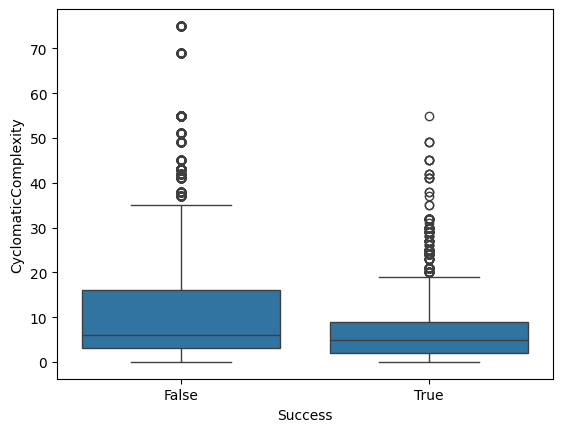

In [11]:
print(data.describe())

# Visualization (e.g., using seaborn or matplotlib)
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Success', y='CyclomaticComplexity', data=data)
plt.show()

In [12]:
error = [bd.issue_description_type for bd in all_data]
successes = [bd.success for bd in all_data]
failures = [not bd.success for bd in all_data]
complexity = [not bd.success for bd in all_data]

data = pd.DataFrame({
    'errorType': error,
    'Success': successes,
    'Failures': failures,
    'CyclomaticComplexity': complexity
})
success_counts = data.groupby('errorType')['Failures'].sum()
print(success_counts)
success_counts = data.groupby('errorType')['Success'].sum()
print(success_counts)


errorType
0    12440
1     1293
2     1204
3      584
Name: Failures, dtype: int64
errorType
0    3560
1     435
2     268
3     376
Name: Success, dtype: int64


In [13]:
print(stats.shapiro(data['CyclomaticComplexity']))

ShapiroResult(statistic=0.5206434726715088, pvalue=0.0)


/home/nikhil/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [14]:
t_test_result = stats.ttest_ind(
    data[data['Success'] == 1]['CyclomaticComplexity'],
    data[data['Success'] == 0]['CyclomaticComplexity']
)

# For non-normally distributed data
mwu_test_result = stats.mannwhitneyu(
    data[data['Success'] == 1]['CyclomaticComplexity'],
    data[data['Success'] == 0]['CyclomaticComplexity']
)

/home/nikhil/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [15]:
# Assuming t_test_result is the result of your t-test
print(f"P-value: {t_test_result.pvalue:.4f}")

if t_test_result.pvalue <= 0.05:
    print("The result is statistically significant. We reject the null hypothesis.")
    print("There is significant evidence to suggest that cyclomatic complexity affects the success of BugData.")
else:
    print("The result is not statistically significant. We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that cyclomatic complexity affects the success of BugData.")

P-value: 0.0000
The result is statistically significant. We reject the null hypothesis.
There is significant evidence to suggest that cyclomatic complexity affects the success of BugData.


In [16]:
t_test_result.pvalue

0.0

In [17]:
mwu_test_result

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [18]:
t_test_result

TtestResult(statistic=-inf, pvalue=0.0, df=20158.0)

In [19]:
prompt_length = [bd.prompt_length for bd in all_data]
successes = [bd.success for bd in all_data]

In [20]:
data = pd.DataFrame({
    'PromptLength': prompt_length,
    'Success': successes
})

       PromptLength
count  2.016000e+04
mean   1.516964e+04
std    5.868338e+04
min    7.500000e+01
25%    2.981000e+03
50%    5.859000e+03
75%    1.167200e+04
max    1.332822e+06


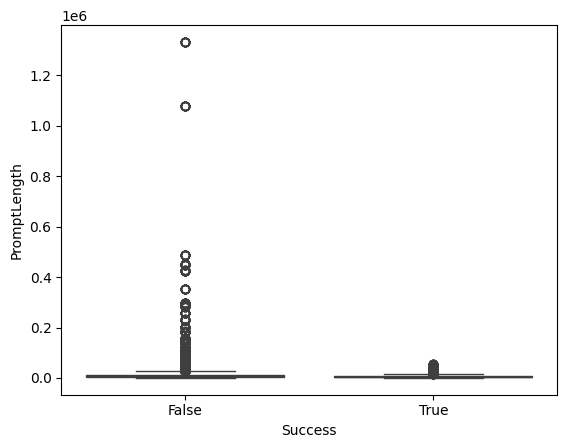

In [21]:
print(data.describe())

sns.boxplot(x='Success', y='PromptLength', data=data)
plt.show()

In [22]:
print(stats.shapiro(data['PromptLength']))

ShapiroResult(statistic=0.1665058732032776, pvalue=0.0)


/home/nikhil/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [23]:
t_test_result = stats.ttest_ind(
    data[data['Success'] == 1]['PromptLength'],
    data[data['Success'] == 0]['PromptLength']
)


In [24]:
t_test_result

TtestResult(statistic=-10.262747852664749, pvalue=1.192615366590284e-24, df=20158.0)

In [25]:
prompt_length = [bd.bitvector[-1] for bd in all_data]
successes = [bd.success for bd in all_data]

In [26]:
cot = [int(bd.bitvector[-1]) for bd in all_data]
successes = [bd.success for bd in all_data]

In [27]:
data = pd.DataFrame({
    'CoT': cot,
    'Success': successes
})

                CoT
count  20160.000000
mean       0.500000
std        0.500012
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000


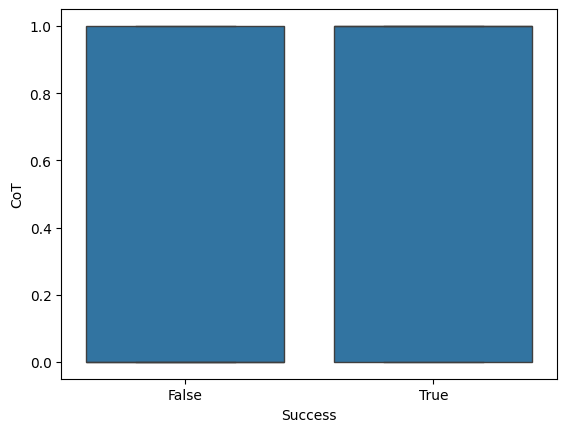

In [28]:
print(data.describe())

sns.boxplot(x='Success', y='CoT', data=data)
plt.show()

In [29]:
cot[0]

0

In [30]:
success_counts = data.groupby('CoT')['Success'].sum()

In [31]:
success_counts

CoT
0    1987
1    2652
Name: Success, dtype: int64

In [32]:
len(data)

20160

In [33]:
success_counts = data[data['Success'] == 'success'].groupby('CoT').size()
print(success_counts)

Series([], dtype: int64)


In [34]:
success_counts = data.groupby('CoT')['Success'].sum()

In [35]:
success_counts

CoT
0    1987
1    2652
Name: Success, dtype: int64

In [36]:
data.shape

(20160, 2)

In [37]:
data

,CoT,Success
0,0,True
1,0,False
2,1,True
3,1,False
4,0,False
...,...,...
20155,1,False
20156,0,False
20157,0,False
20158,0,False


In [38]:
data.groupby('CoT')['Success']

In [39]:
data['CoT'].value_counts()

CoT
0    10080
1    10080
Name: count, dtype: int64

In [40]:
cot = [int(bd.bitvector[-1]) for bd in all_data]


In [41]:
bits = []

In [42]:
for bit in range(0, 7):
    bits.append([int(data.bitvector[bit]) for data in all_data])

In [43]:
nd = []
for bit_index, bit_data in enumerate(bits):
    for data_point in bit_data:
        nd.append({'BitIndex': bit_index, 'Data': data_point, "Success": successes})

In [44]:
df = pd.DataFrame(nd)

In [45]:
df

,BitIndex,Data,Success
0,0,1,"[True, False, True, False, False, False, True,..."
1,0,1,"[True, False, True, False, False, False, True,..."
2,0,1,"[True, False, True, False, False, False, True,..."
3,0,1,"[True, False, True, False, False, False, True,..."
4,0,1,"[True, False, True, False, False, False, True,..."
...,...,...,...
141115,6,1,"[True, False, True, False, False, False, True,..."
141116,6,0,"[True, False, True, False, False, False, True,..."
141117,6,0,"[True, False, True, False, False, False, True,..."
141118,6,0,"[True, False, True, False, False, False, True,..."


In [46]:
df = pd.DataFrame(data)

In [47]:
# Prepare the data
data = []
all_data = [data for data in all_data if data.bitvector == data.available_bv]
for bug_data in all_data:
    for i, bit in enumerate(bug_data.available_bv):
        data.append({
            'bug_id': bug_data.bug_id,
            'BitPosition': i,
            'Bit': int(bit),
            'Success': int(bug_data.success)
        })

df = pd.DataFrame(data)

# Initialize a dictionary to store the averages
avg_success_per_bug_per_bit = {}

# Iterate over each bug_id and each bit position
bug_ids = df['bug_id'].unique()
for bug_id in bug_ids:
    avg_success_per_bug_per_bit[bug_id] = {}
    for bit_position in range(7):
        # Calculate average success for set bit
        satisfied_data_set = df[(df['bug_id'] == bug_id) & (df['BitPosition'] == bit_position) & (df['Bit'] == 1)]
        avg_success_set = satisfied_data_set['Success'].mean()
        avg_success_per_bug_per_bit[bug_id][f'Bit_{bit_position}_Set_Avg_Success'] = avg_success_set if not pd.isna(avg_success_set) else 0

        # Calculate average success for unset bit
        satisfied_data_unset = df[(df['bug_id'] == bug_id) & (df['BitPosition'] == bit_position) & (df['Bit'] == 0)]
        avg_success_unset = satisfied_data_unset['Success'].mean()
        avg_success_per_bug_per_bit[bug_id][f'Bit_{bit_position}_Unset_Avg_Success'] = avg_success_unset if not pd.isna(avg_success_unset) else 0

# Convert the results to a DataFrame for better visualization
avg_success_df = pd.DataFrame.from_dict(avg_success_per_bug_per_bit, orient='index')

# Display the DataFrame
print(avg_success_df)

            Bit_0_Set_Avg_Success  Bit_0_Unset_Avg_Success  \
luigi:18                 0.218750                        0   
luigi:33                 0.000000                        0   
luigi:15                 0.234375                        0   
luigi:28                 0.609375                        0   
luigi:20                 0.171875                        0   
...                           ...                      ...   
thefuck:7                0.062500                        0   
thefuck:31               0.250000                        0   
thefuck:4                0.156250                        0   
thefuck:11               0.031250                        0   
thefuck:23               0.000000                        0   

            Bit_1_Set_Avg_Success  Bit_1_Unset_Avg_Success  \
luigi:18                  0.18750                  0.25000   
luigi:33                  0.00000                  0.00000   
luigi:15                  0.12500                  0.34375   
luigi:2

In [48]:
summary_row = avg_success_df.sum()

# Convert the Series to a DataFrame for better visualization
summary_df = pd.DataFrame(summary_row).transpose()

# Rename the index for clarity
summary_df.index = ['Total_Avg_Success']

# Display the summary DataFrame
print(summary_df)

                   Bit_0_Set_Avg_Success  Bit_0_Unset_Avg_Success  \
Total_Avg_Success               72.84375                      0.0   

                   Bit_1_Set_Avg_Success  Bit_1_Unset_Avg_Success  \
Total_Avg_Success               44.46875                 73.09375   

                   Bit_2_Set_Avg_Success  Bit_2_Unset_Avg_Success  \
Total_Avg_Success                73.6875                     72.0   

                   Bit_3_Set_Avg_Success  Bit_3_Unset_Avg_Success  \
Total_Avg_Success                91.5625                   54.125   

                   Bit_4_Set_Avg_Success  Bit_4_Unset_Avg_Success  \
Total_Avg_Success                  72.25                 68.96875   

                   Bit_5_Set_Avg_Success  Bit_5_Unset_Avg_Success  \
Total_Avg_Success                   67.0                 60.78125   

                   Bit_6_Set_Avg_Success  Bit_6_Unset_Avg_Success  
Total_Avg_Success               83.09375                 62.59375  


In [49]:
result = df.groupby(['BitPosition', 'Bit']).agg(
    Successes=('Success', sum),
    Total=('Success', 'size')
).reset_index()

result['Failures'] = result['Total'] - result['Successes']

result

/tmp/ipykernel_1459123/959930614.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  result = df.groupby(['BitPosition', 'Bit']).agg(


,BitPosition,Bit,Successes,Total,Failures
0,0,1,3203,13280,10077
1,1,0,1991,8360,6369
2,1,1,1212,4920,3708
3,2,0,1583,6640,5057
4,2,1,1620,6640,5020
5,3,0,1269,6640,5371
6,3,1,1934,6640,4706
7,4,0,1557,6824,5267
8,4,1,1646,6456,4810
9,5,0,1503,7752,6249


In [50]:
result

,BitPosition,Bit,Successes,Total,Failures
0,0,1,3203,13280,10077
1,1,0,1991,8360,6369
2,1,1,1212,4920,3708
3,2,0,1583,6640,5057
4,2,1,1620,6640,5020
5,3,0,1269,6640,5371
6,3,1,1934,6640,4706
7,4,0,1557,6824,5267
8,4,1,1646,6456,4810
9,5,0,1503,7752,6249


In [51]:
result_sorted = result.sort_values(by='Successes', ascending=False)


In [52]:
result_sorted


,BitPosition,Bit,Successes,Total,Failures
0,0,1,3203,13280,10077
1,1,0,1991,8360,6369
6,3,1,1934,6640,4706
12,6,1,1821,6640,4819
10,5,1,1700,5528,3828
8,4,1,1646,6456,4810
4,2,1,1620,6640,5020
3,2,0,1583,6640,5057
7,4,0,1557,6824,5267
9,5,0,1503,7752,6249


In [53]:
df_bit_set = df[df['Bit'] == 1].groupby('BitPosition').agg(Successes_Set=('Success', sum))
df_bit_not_set = df[df['Bit'] == 0].groupby('BitPosition').agg(Successes_Not_Set=('Success', sum))

# Merge the two DataFrames on BitPosition
merged_df = df_bit_set.merge(df_bit_not_set, on='BitPosition', how='outer')


/tmp/ipykernel_1459123/3989938024.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_bit_set = df[df['Bit'] == 1].groupby('BitPosition').agg(Successes_Set=('Success', sum))
/tmp/ipykernel_1459123/3989938024.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_bit_not_set = df[df['Bit'] == 0].groupby('BitPosition').agg(Successes_Not_Set=('Success', sum))


In [54]:
merged_df.fillna(0, inplace=True)

merged_df['Difference'] = merged_df['Successes_Set'] - merged_df['Successes_Not_Set']

merged_df.reset_index(inplace=True)

print(merged_df)

   BitPosition  Successes_Set  Successes_Not_Set  Difference
0            0           3203                0.0      3203.0
1            1           1212             1991.0      -779.0
2            2           1620             1583.0        37.0
3            3           1934             1269.0       665.0
4            4           1646             1557.0        89.0
5            5           1700             1503.0       197.0
6            6           1821             1382.0       439.0


In [55]:
merged_df = merged_df.sort_values(by='Difference', ascending=False)


In [56]:
merged_df

,BitPosition,Successes_Set,Successes_Not_Set,Difference
0,0,3203,0.0,3203.0
3,3,1934,1269.0,665.0
6,6,1821,1382.0,439.0
5,5,1700,1503.0,197.0
4,4,1646,1557.0,89.0
2,2,1620,1583.0,37.0
1,1,1212,1991.0,-779.0


In [57]:
merged_df.rename(columns={'BitPosition': 'Feature'}, inplace=True)

In [58]:
index_mapping = {
    0: 'the function code',
    1: 'class data',
    2: 'file data',
    3: 'test data',
    4: 'dynamic variable data',
    5: 'Github data',
    6: 'CoT data'
}

# Apply the mapping to the DataFrame's index
merged_df['Feature'] = merged_df['Feature'].map(index_mapping)

# Optionally, set 'Feature' as the new index
merged_df.set_index('Feature', inplace=True)
merged_df

,Successes_Set,Successes_Not_Set,Difference
Feature,,,
the function code,3203,0.0,3203.0
test data,1934,1269.0,665.0
CoT data,1821,1382.0,439.0
Github data,1700,1503.0,197.0
dynamic variable data,1646,1557.0,89.0
file data,1620,1583.0,37.0
class data,1212,1991.0,-779.0


In [59]:
from itertools import combinations
all_data = create_bug_data_objects_395(facts_location, easy=True)
all_data += create_bug_data_objects_395(facts_location_395)

# Prepare your data
data = []
for bug_data in all_data:
    row = {'Success': bug_data.success}
    for i, bit in enumerate(bug_data.bitvector):
        row[f'Bit_{i}'] = int(bit)
    data.append(row)

df = pd.DataFrame(data)

# Number of bits in the bitvector
num_bits = len(all_data[0].bitvector)

# Initialize a dictionary to store the results
dependency_results = {}
from scipy.stats import chi2_contingency
# Iterate over pairs of bits
for i, j in combinations(range(num_bits), 2):
    # Create a contingency table for each pair of bits
    contingency_table = pd.crosstab(
        index=[df[f'Bit_{i}'], df[f'Bit_{j}']], 
        columns=df['Success'], 
        margins=False
    )
    dependency_results[f'Bit_{i}, Bit_{j}'] = contingency_table

chi_square_results = {}
for bit_pair, table in dependency_results.items():
    chi2, p, dof, expected = chi2_contingency(table)
    
    # Print actual and expected counts for comparison
    print(f"Bit Pair: {bit_pair}")

    # Calculate and print conditional probabilities of success
    total_counts = table.sum(axis=1)
    probability_of_success = table[True] / total_counts
    print("Probability of Success:\n", probability_of_success)


Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)
Error computing cyclomatic complexity: unexpected indent (<unknown>, line 1)

In [60]:
for bit_pair, table in dependency_results.items():
    print(f"Bit Pair: {bit_pair}")

    # Calculating probabilities
    prob_success = {}
    total_counts = table.sum(axis=1)
    
    for state in [(1, 1), (0, 1), (1, 0), (0, 0)]:
        success_count = table.loc[state, True] if state in table.index else 0
        total_count = total_counts.loc[state] if state in total_counts.index else 0
        prob_success[state] = success_count / total_count if total_count > 0 else 0

    print("Probabilities of Success:")
    for state, prob in prob_success.items():
        print(f"State {state}: {prob}")

    if prob_success[(1, 1)] < max(prob_success.values()):
        print("-> (1, 1) does NOT have the Highest probability of success for this pair.")
    else:
        print("-> (1, 1) has the highest probability of success for this pair.")

    print("\n")

Bit Pair: Bit_0, Bit_1
Probabilities of Success:
State (1, 1): 0.2302579365079365
State (0, 1): 0
State (1, 0): 0.22996031746031745
State (0, 0): 0
-> (1, 1) has the highest probability of success for this pair.


Bit Pair: Bit_0, Bit_2
Probabilities of Success:
State (1, 1): 0.229265873015873
State (0, 1): 0
State (1, 0): 0.23095238095238096
State (0, 0): 0
-> (1, 1) does NOT have the Highest probability of success for this pair.


Bit Pair: Bit_0, Bit_3
Probabilities of Success:
State (1, 1): 0.2879960317460317
State (0, 1): 0
State (1, 0): 0.17222222222222222
State (0, 0): 0
-> (1, 1) has the highest probability of success for this pair.


Bit Pair: Bit_0, Bit_4
Probabilities of Success:
State (1, 1): 0.24186507936507937
State (0, 1): 0
State (1, 0): 0.2183531746031746
State (0, 0): 0
-> (1, 1) has the highest probability of success for this pair.


Bit Pair: Bit_0, Bit_5
Probabilities of Success:
State (1, 1): 0.2675595238095238
State (0, 1): 0
State (1, 0): 0.19265873015873017
Sta

In [61]:
len(all_data)


20160

In [62]:
from collections import defaultdict

# Initialize a dictionary to store the aggregated data
aggregated_data = defaultdict(lambda: {'success_count': 0, 'total_tries': 0})

# Iterate over all_data and aggregate
for bug_data in all_data:
    # Create a unique key for each (bug_id, available_bv) pair
    key = (bug_data.bug_id, tuple(bug_data.available_bv))  # Assuming available_bv is list-like

    # Aggregate success_count and increment total_tries
    aggregated_data[key]['success_count'] += bug_data.success_count
    aggregated_data[key]['total_tries'] += 3  # Increment by 3 as each entry represents 3 tries

# Convert the aggregated data to a DataFrame for easier analysis
aggregated_df = pd.DataFrame([
    {'bug_id': k[0], 'available_bv': k[1], 'success_count': v['success_count'], 'total_tries': v['total_tries']}
    for k, v in aggregated_data.items()
])

# Display the DataFrame
#print(aggregated_df)
print(aggregated_df.sort_values(by=['success_count', 'total_tries'], ascending=False))

              bug_id           available_bv  success_count  total_tries
9379       ansible:5  (1, 0, 0, 1, 0, 1, 0)             12           12
11136  youtube-dl:11  (1, 0, 1, 1, 1, 0, 0)             12           12
11145  youtube-dl:11  (1, 0, 0, 1, 1, 0, 0)             12           12
11146  youtube-dl:11  (1, 0, 0, 1, 0, 0, 1)             12           12
11147  youtube-dl:11  (1, 0, 1, 1, 0, 0, 0)             12           12
...              ...                    ...            ...          ...
12842      thefuck:3  (1, 0, 0, 0, 0, 0, 1)              0            3
12843      thefuck:3  (1, 0, 1, 1, 1, 0, 1)              0            3
12844      thefuck:3  (1, 0, 0, 0, 0, 0, 0)              0            3
12845      thefuck:3  (1, 0, 1, 0, 0, 0, 0)              0            3
12847      thefuck:3  (1, 0, 1, 0, 0, 1, 1)              0            3

[13280 rows x 4 columns]


In [63]:
aggregated_df['success_probability'] = aggregated_df['success_count'] / aggregated_df['total_tries']

summed_probabilities = aggregated_df.groupby('available_bv')['success_probability'].sum()

total_unique_bugs = aggregated_df['bug_id'].nunique()

average_probabilities_per_bug = summed_probabilities / total_unique_bugs
average_probabilities_df = average_probabilities_per_bug.reset_index()
average_probabilities_df.columns = ['bitvector', 'avg_success_probability']

ranked_bitvectors = average_probabilities_df.sort_values(by='avg_success_probability', ascending=False).reset_index(drop=True)

print(ranked_bitvectors)

                bitvector  avg_success_probability
0   (1, 0, 1, 1, 0, 0, 1)                 0.174868
1   (1, 0, 0, 1, 1, 0, 1)                 0.173810
2   (1, 0, 0, 1, 0, 0, 1)                 0.170635
3   (1, 0, 1, 1, 1, 1, 1)                 0.162963
4   (1, 0, 1, 1, 1, 0, 1)                 0.159259
..                    ...                      ...
59  (1, 1, 1, 0, 1, 0, 0)                 0.032804
60  (1, 1, 0, 0, 0, 0, 1)                 0.028571
61  (1, 1, 1, 0, 0, 0, 0)                 0.021693
62  (1, 1, 1, 0, 0, 0, 1)                 0.021164
63  (1, 1, 0, 0, 0, 0, 0)                 0.020106

[64 rows x 2 columns]


In [64]:
target_bitvector = ('1', '1', '1', '1', '1', '1', '1')
print(ranked_bitvectors[ranked_bitvectors['bitvector']  == target_bitvector])
rank_row = ranked_bitvectors[ranked_bitvectors['bitvector'] == target_bitvector]


                bitvector  avg_success_probability
28  (1, 1, 1, 1, 1, 1, 1)                 0.098413


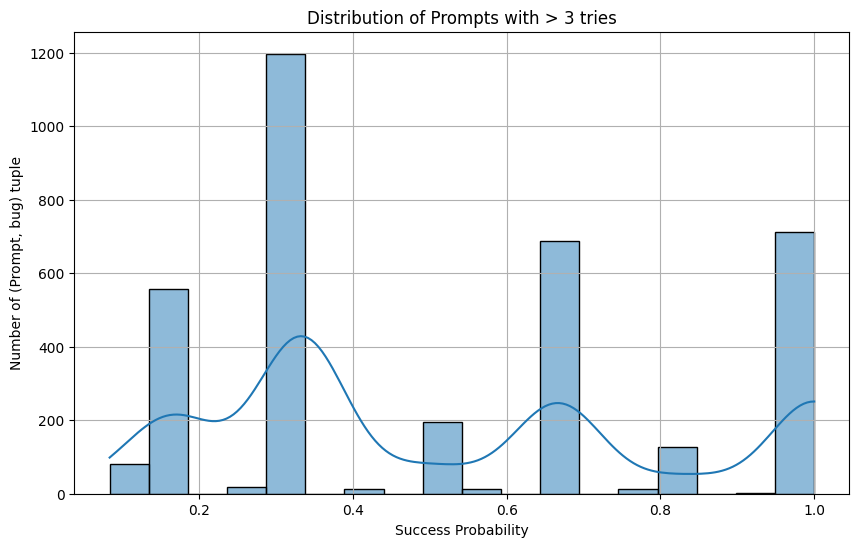

In [65]:
aggregated_df['success_probability'] = aggregated_df['success_count'] / aggregated_df['total_tries']
pruned_df = aggregated_df[aggregated_df['success_probability'] > 0]

# Plotting the distribution of success_probability
plt.figure(figsize=(10, 6))
sns.histplot(pruned_df['success_probability'], kde=True, binwidth=0.05)

plt.title('Distribution of Prompts with > 3 tries')
plt.xlabel('Success Probability')
plt.ylabel('Number of (Prompt, bug) tuple')
plt.grid(True)
plt.show()

In [66]:
aggregated_df['success_probability'] = aggregated_df['success_count'] / aggregated_df['total_tries']

optimal_bvs = aggregated_df.loc[aggregated_df.groupby('bug_id')['success_probability'].idxmax()]

expected_number_for_optimal_multiplexer = optimal_bvs['success_probability'].sum()

expected_number_for_optimal_multiplexer

143.25

In [67]:
optimal_bvs

,bug_id,available_bv,success_count,total_tries,success_probability
9576,ansible:1,"(1, 0, 1, 1, 0, 0, 0)",0,24,0.000000
9416,ansible:12,"(1, 0, 1, 1, 1, 0, 0)",0,3,0.000000
9342,ansible:14,"(1, 0, 1, 1, 1, 1, 1)",1,3,0.333333
9496,ansible:15,"(1, 0, 0, 1, 0, 1, 0)",1,6,0.166667
9403,ansible:3,"(1, 1, 0, 1, 0, 0, 1)",1,6,0.166667
...,...,...,...,...,...
10994,youtube-dl:43,"(1, 0, 0, 1, 1, 0, 1)",2,12,0.166667
10448,youtube-dl:5,"(1, 0, 1, 1, 1, 0, 0)",1,12,0.083333
11090,youtube-dl:7,"(1, 0, 0, 1, 1, 0, 1)",1,12,0.083333
10717,youtube-dl:8,"(1, 1, 1, 0, 0, 0, 0)",1,6,0.166667


In [68]:
ranked_bitvectors[:20]

,bitvector,avg_success_probability
0,"(1, 0, 1, 1, 0, 0, 1)",0.174868
1,"(1, 0, 0, 1, 1, 0, 1)",0.173810
2,"(1, 0, 0, 1, 0, 0, 1)",0.170635
3,"(1, 0, 1, 1, 1, 1, 1)",0.162963
4,"(1, 0, 1, 1, 1, 0, 1)",0.159259
5,"(1, 0, 1, 1, 0, 1, 1)",0.155556
6,"(1, 0, 0, 1, 0, 1, 1)",0.155291
7,"(1, 0, 0, 0, 1, 1, 1)",0.149206
8,"(1, 0, 0, 1, 1, 1, 1)",0.137037
9,"(1, 0, 1, 0, 1, 1, 1)",0.133333


In [69]:
existing_pairs = set(aggregated_df.apply(lambda x: (x['bug_id'], tuple(x['available_bv'])), axis=1))
new_rows = []
missing_probabilities = []
for bug_data in all_data:
    key = (bug_data.bug_id, tuple(bug_data.bitvector))
    if key not in existing_pairs:
        prob = aggregated_df.loc[
            (aggregated_df['bug_id'] == bug_data.bug_id) & 
            (aggregated_df['available_bv'] == tuple(bug_data.available_bv)),
            'success_probability'
        ].max() 
        new_row = {
            'bug_id': bug_data.bug_id, 
            'available_bv': tuple(bug_data.bitvector),
            'success_count': None,
            'total_tries': None,  
            'success_probability': prob
        }
        new_rows.append(new_row)

# Concatenate the new rows to the original DataFrame
if new_rows:
    aggregated_df = pd.concat([aggregated_df, pd.DataFrame(new_rows)], ignore_index=True)
summed_probabilities = aggregated_df.groupby('available_bv')['success_probability'].sum()

total_unique_bugs = aggregated_df['bug_id'].nunique()

average_probabilities_per_bug = summed_probabilities / total_unique_bugs
average_probabilities_df = average_probabilities_per_bug.reset_index()
average_probabilities_df.columns = ['bitvector', 'avg_success_probability']

ranked_bitvectors = average_probabilities_df.sort_values(by='avg_success_probability', ascending=False).reset_index(drop=True)
ranked_bitvectors["expected_fixes"] = ranked_bitvectors["avg_success_probability"]*315
ranked_bitvectors[:10]

,bitvector,avg_success_probability,expected_fixes
0,"(1, 0, 1, 1, 1, 1, 1)",0.226984,71.500000
1,"(1, 1, 0, 1, 0, 1, 1)",0.222487,70.083333
2,"(1, 1, 1, 1, 1, 1, 1)",0.217725,68.583333
3,"(1, 0, 1, 1, 0, 1, 1)",0.217460,68.500000
4,"(1, 1, 1, 1, 0, 1, 1)",0.210317,66.250000
5,"(1, 0, 0, 1, 0, 1, 1)",0.210317,66.250000
6,"(1, 1, 0, 1, 1, 1, 1)",0.206614,65.083333
7,"(1, 0, 0, 1, 1, 1, 1)",0.200265,63.083333
8,"(1, 0, 0, 1, 1, 0, 1)",0.185979,58.583333
9,"(1, 1, 1, 1, 1, 0, 1)",0.184656,58.166667


In [70]:
from random import gauss

probabilities_dict = {(row['bug_id'], row['available_bv']): row['success_probability']
                      for _, row in aggregated_df.iterrows()}

# Update success_probability in all_data
for data in all_data:
    key = (data.bug_id, tuple(data.available_bv))
    if key in probabilities_dict:
        data.success_probability = probabilities_dict[key]
        # Check if success_probability is between 0.2 and 0.8
        # Modify success_probability using Gaussian randomness
        adjustment = gauss(mu=0.2, sigma=0.1)  # Example values for mu and sigma
        data.success_probability += 0
        
        data.success_probability = max(0, min(data.success_probability, 1))

    else:
        assert False

In [71]:
optimal_bvs = aggregated_df.loc[aggregated_df.groupby('bug_id')['success_probability'].idxmax()]
sum_optimal_probabilities = optimal_bvs['success_probability'].sum()

# Calculate the total expected number
total_expected_number = sum_optimal_probabilities

# Output the result
print("Total expected number for the optimal multiplexer:", total_expected_number)


Total expected number for the optimal multiplexer: 143.25


In [72]:
# Function to convert success_probability to a class
def probability_to_class(prob, num_classes=10):
    scaled_prob = prob * num_classes
    # Round to the nearest integer and handle the edge case where the probability is exactly 1
    return round(scaled_prob) if prob < 1 else num_classes - 1

def estimate_score(model, test_data):
    test_groups = {}
    for bug in test_data:
        if bug.bug_id not in test_groups:
            test_groups[bug.bug_id] = []
        test_groups[bug.bug_id].append(bug)

    successful_selections = 0
    optimal_success_count = 0
    best_bitvectors = {}  # To store the best bitvector for each bug_id

    for bug_id, bugs in test_groups.items():
        # Get predicted classes for each bug
        bug_predictions = [
            (bug, model.predict([bug.feature_vector])[0]) for bug in bugs
        ]

        # Sort bugs by their predicted class in descending order
        sorted_bugs = sorted(bug_predictions, key=lambda x: x[1], reverse=True)
        best_bug = sorted_bugs[0][0]

        best_bitvectors[bug_id] = best_bug.bitvector  # Store the best bitvector
        actual_class = probability_to_class(best_bug.success_probability, 10)
        if best_bug.success:
            successful_selections += 1
        # Check for optimal success in the group
        if any(probability_to_class(bug.success_probability, 10) == 9 for bug in bugs):
            optimal_success_count += 1
            

    # Calculate and print the success rates
    success_rate = successful_selections / len(test_groups)
    optimal_rate = optimal_success_count / len(test_groups)
    print(f"Success rate: {success_rate}")
    print(f"Optimal success rate: {optimal_rate}")
    print(f"Optimal success count: {successful_selections}")

    

    # Process each group in test_groups
    bitvector_success_rates = {}
    for bug_id, bugs in test_groups.items():
        bv_set = set()
        for bug in bugs:
            bv_set.add(bug.bitvector)
            if bug.bitvector not in bitvector_success_rates:
                bitvector_success_rates[bug.bitvector] = {"successes": 0, "total": 0}

            bitvector_success_rates[bug.bitvector]["total"] += 1
            if bug.success:
                bitvector_success_rates[bug.bitvector]["successes"] += 1

    # Calculate success rate for each bitvector
    for bitvector, stats in bitvector_success_rates.items():
        success_rate = stats["successes"] / stats["total"]
        bitvector_success_rates[bitvector]["success_rate"] = success_rate
    print(f"Best bitvector (1001011): {bitvector_success_rates['1001011']}")
    # Find the bitvectors with the highest success rates
    highest_success_rate = max(
        rate["success_rate"] for rate in bitvector_success_rates.values()
    )
    best_bitvectors = [
        (bitvector, rate)
        for bitvector, rate in bitvector_success_rates.items()
        if rate["success_rate"] == highest_success_rate
    ]

    # Print the best bitvectors
    print(f"Bitvectors with the highest success rate: {best_bitvectors}")


def train_and_test(all_data, include_list, model):
    include_set = set(include_list)
    # Create a unique set of bug IDs not in the include_list
    unique_bug_ids = set(
        bug.bug_id for bug in all_data if bug.bug_id not in include_set
    )
    include_set = set([bug.bug_id for bug in all_data if bug.bug_id in include_set])
    # Calculate the required size of the training set for a 50/50 split
    total_unique_ids = len(unique_bug_ids) + len(include_set)
    required_train_size = total_unique_ids // 2

    additional_ids_needed = required_train_size - len(include_set)

    # Split the remaining IDs to fill up the training set
    additional_train_ids, test_ids = train_test_split(
        sorted(list(unique_bug_ids)), train_size=additional_ids_needed, random_state=42
    )
    train_ids = set(list(include_set) + additional_train_ids)
    # Prepare the data splits
    train_data = [bug for bug in all_data if bug.bug_id in train_ids]
    test_data = [bug for bug in all_data if bug.bug_id in test_ids]
    # Define the number of classes for classification
    num_classes = 10


    # Prepare feature vectors and class labels
    X_train = [bug.feature_vector for bug in train_data]
    y_train = [probability_to_class(bug.success_probability) for bug in train_data]

    X_test = [bug.feature_vector for bug in test_data]
    y_test = [probability_to_class(bug.success_probability) for bug in test_data]

    # Parameter tuning using GridSearchCV
    param_grid_rf = {
        "n_estimators": [100, 200, 300],  # Increased the upper limit for more averaging
        "max_depth": [5, 10, 15],  # Removed the deepest trees to prevent overfitting
        #"min_samples_split": [2, 5, 10],  # Uncommented to control the minimum size of a split
        #"min_samples_leaf": [1, 2, 4],  # Uncommented to control the minimum size of a leaf
        "max_features": ["sqrt", "log2", None],  # Added 'None' for using all features
        "bootstrap": [True],  # True is generally better for Random Forest to ensure diversity
        "criterion": ["gini", "entropy"],  # Both criteria are useful
        #"max_leaf_nodes": [None, 10, 20, 30],  # Added to limit the number of leaf nodes
        "oob_score": [True, False]  # Out-of-bag samples to estimate generalization accuracy
    }
    # Parameter grid for XGBoost
    param_grid_xgb = {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 15, 20],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1],
        "colsample_bytree": [0.5, 0.7, 1],
    }
    if model == "rf":
        model = RandomForestClassifier(random_state=42, class_weight="balanced")
        grid_search = GridSearchCV(model, param_grid_rf, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
    elif model == "xgb":
        model_xgb = XGBClassifier(
            random_state=42, use_label_encoder=False, eval_metric="logloss"
        )
        grid_search = GridSearchCV(
            model_xgb, param_grid_xgb, cv=5, verbose=3, n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

    # Use the best estimator to train the model
    best_model = grid_search.best_estimator_

    # Assuming 'model' is your trained RandomForestClassifier or RandomForestRegressor instance
    importances = best_model.feature_importances_

    # To make it easier to interpret, you can sort the features by importance
    indices = np.argsort(importances)[::-1]

    # Print the feature rankings
    print("Feature ranking:")

    for f in range(len(X_train[0])):  # Assuming X_train is your training feature set
        print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")

    estimate_score(best_model, test_data)
    estimate_score(best_model, train_data)
    estimate_score(best_model, test_data + train_data)


In [73]:
train_and_test_normal(all_data, include_list, "rf")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Feature ranking:
1. feature 0 (0.32983330921013926)
2. feature 8 (0.22088047868377841)
3. feature 4 (0.17065906844769324)
4. feature 6 (0.08611016360609437)
5. feature 10 (0.08172969422334511)
6. feature 9 (0.05828561272552277)
7. feature 7 (0.03052276866920316)
8. feature 5 (0.0147180664552945)
9. feature 2 (0.005124505164662906)
10. feature 3 (0.002136332814266226)
11. feature 1 (0.0)
Model Accuracy: 0.3860759493670886, Optimal Accuracy: 0.7784810126582279, Successful Selections: 61, Total Groups: 158
Best bitvector (1001011): {'successes': 61, 'total': 158, 'success_rate': 0.3860759493670886}
Bitvectors with the highest success rate: [('1011111', {'successes': 64, 'total': 158, 'success_rate': 0.4050632911392405})]
Model Accuracy: 0.3821656050955414, Optimal Accuracy: 0.7579617834394905, Successful Selections: 60, Total Groups: 157
Best bitvector (1001011): {'successes': 58, 'total': 157, 'success_rate': 0.36942675159235